In [1]:
import neutromeratio
from openmmtools.constants import kB
from simtk import unit
import numpy as np
import pickle
import mdtraj as md
import torchani
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import simtk

In [21]:
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

# specify the system you want to simulate
#name = 'molDWRow_298'
name = 'molDWRow_37'
#name = 'molDWRow_45'
#name = 'molDWRow_160'
#name = 'molDWRow_590'


from_mol_tautomer_idx = 2
to_mol_tautomer_idx = 1


t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t2-smiles']

# generate both rdkit mol
mols = { 't1' : neutromeratio.generate_rdkit_mol(t1_smiles), 't2' : neutromeratio.generate_rdkit_mol(t2_smiles) }
from_mol = mols[f"t{from_mol_tautomer_idx}"]
to_mol = mols[f"t{to_mol_tautomer_idx}"]
ani_input = neutromeratio.from_mol_to_ani_input(from_mol)

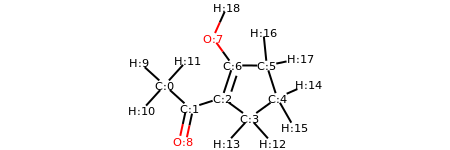

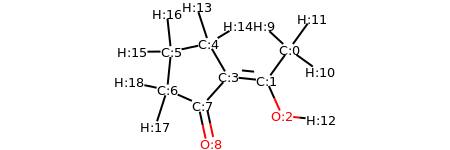

In [22]:
neutromeratio.display_mol(mols['t1'])
neutromeratio.display_mol(mols['t2'])

[utils.py:48 - get_donor_atom_idx()] Index of atom that moves: 12.
[utils.py:54 - get_donor_atom_idx()] Index of atom that donates hydrogen: 2
[utils.py:72 - get_donor_atom_idx()] Index of atom that accepts hydrogen: 8


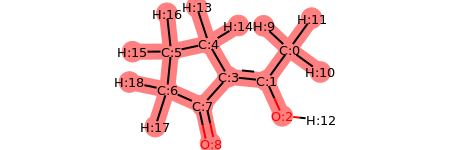

In [23]:
# extract hydrogen donor idx and hydrogen idx for from_mol
tautomer_transformation = neutromeratio.get_donor_atom_idx(from_mol, to_mol)
platform = 'cpu'
device = torch.device(platform)
model = neutromeratio.ani.LinearAlchemicalANI(alchemical_atoms=tautomer_transformation['hydrogen_idx'])
model = model.to(device)
torch.set_num_threads(2)

In [24]:
tautomer_transformation

{'donor_idx': 2, 'hydrogen_idx': 12, 'acceptor_idx': 8}

In [27]:
energy_function = neutromeratio.ANI1_force_and_energy(device = device,
                                          model = model,
                                          atom_list = ani_input['atom_list'],
                                          platform = platform,
                                          tautomer_transformation = tautomer_transformation,
                                          bond_restraint=True)

langevin = neutromeratio.LangevinDynamics(atom_list = ani_input['atom_list'],
                            temperature = 300*unit.kelvin,
                            force = energy_function,
                            tautomer_transformation = tautomer_transformation)

hydrogen_mover = neutromeratio.NonequilibriumMC(donor_idx = tautomer_transformation['donor_idx'], 
                                       hydrogen_idx = tautomer_transformation['hydrogen_idx'], 
                                       acceptor_idx = tautomer_transformation['acceptor_idx'], 
                                       atom_list = ani_input['atom_list'], 
                                       energy_function = energy_function,
                                       langevin_dynamics= langevin)



# initial conditions: coordinates from example were given in units of angstroms   
x0 = np.array(ani_input['coord_list']) * unit.angstrom

print(f"Hydrogen {hydrogen_mover.hydrogen_idx} is moved from atom-idx {hydrogen_mover.donor_idx} to atom-idx {hydrogen_mover.acceptor_idx}.")

hydrogen_mover.performe_md_mc_protocoll(x0, nr_of_mc_trials=20)

[mcmc.py:227 - performe_md_mc_protocoll()] Decoupling hydrogen ...
  0%|          | 0/10 [00:00<?, ?it/s]

Hydrogen 12 is moved from atom-idx 2 to atom-idx 8.


100%|██████████| 10/10 [00:32<00:00,  3.17s/it]
[mcmc.py:239 - performe_md_mc_protocoll()] Moving hydrogen ...
[mcmc.py:243 - performe_md_mc_protocoll()] Recoupling hydrogen ...
 40%|████      | 4/10 [00:11<00:16,  2.77s/it]

KeyboardInterrupt: 

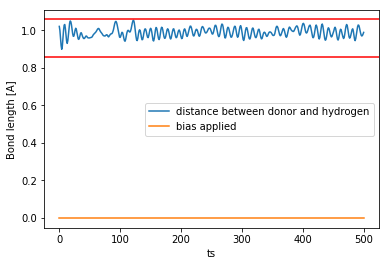

0.988147414953007
0.023927658888046235


In [26]:
import matplotlib.pyplot as plt


distance_list = []
for x in t:
    distance_list.append(neutromeratio.constants.nm_to_angstroms * np.linalg.norm(x[tautomer_transformation['hydrogen_idx']] - x[tautomer_transformation['donor_idx']]))

    
plt.plot(distance_list, label='distance between donor and hydrogen')
plt.plot(energy_function.bias, label='bias applied')
plt.xlabel('ts')
plt.ylabel('Bond length [A]')
plt.axhline(y=0.86, color='r', linestyle='-',)
plt.axhline(y=1.06, color='r', linestyle='-',)
plt.legend()
plt.show()

print(np.mean(distance_list))
print(np.std(distance_list))
